## Convert our solar data from hourly to daily

### Import libraries

In [149]:
import csv
import os
import re
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [150]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 3

### Find data folders

In [151]:
folders = [f.name for f in Path("./data/1991-2005/hourly").iterdir() if f.is_dir()]

### Define the columns to sum, average, and max/min

In [152]:
# Define columns to sum, average, and max/min
energy_columns = ['Glo (Wh/m^2)', 'Dir (Wh/m^2)', 'Dif (Wh/m^2)']
unc_columns = ['Glo Unc (%)', 'Dir Unc (%)', 'Dif Unc (%)']
column_types = ['SUNY', 'METSTAT', 'Meas']

percentage_columns = ['Precip Wat (cm)', 'AOD (unitless)', 'Ozone (cm)', 'Albedo (unitless)']
angle_columns = ['Zenith (deg)', 'Azimuth (deg)']
flag_columns = ['Precip Wat Flg', 'AOD Flg', 'Ozone Flg', 'Albedo Flg']

### Import some example data

In [153]:
# ./data/1991-2005/hourly/690140/690140_1991_solar.csv
df1 = pd.read_csv('./data/1991-2005/hourly/690140/690140_1991_solar.csv')
df2 = pd.read_csv('./data/1991-2005/hourly/690140/690140_2005_solar.csv')
df3 = pd.read_csv('./data/1991-2005/hourly/726798/726798_1991_solar.csv')
df4 = pd.read_csv('./data/1991-2005/hourly/726798/726798_2005_solar.csv')

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [154]:
df.sample(5)

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (Wh/m^2),ETRN (Wh/m^2),SUNY Glo (Wh/m^2),SUNY Glo Unc (%),SUNY Dir (Wh/m^2),SUNY Dir Unc (%),SUNY Dif (Wh/m^2),SUNY Dif Unc (%),METSTAT Glo (Wh/m^2),METSTAT Glo Unc (%),METSTAT Dir (Wh/m^2),METSTAT Dir Unc (%),METSTAT Dif (Wh/m^2),METSTAT Dif Unc (%),METSTAT CSKY Glo (Wh/m^2),METSTAT CSKY Glo Unc (%),METSTAT CSKY Dir (Wh/m^2),METSTAT CSKY Dir Unc (%),METSTAT CSKY Dif (Wh/m^2),METSTAT CSKY Dif Unc (%),Meas Glo (Wh/m^2),Meas Glo Flg,Meas Dir (Wh/m^2),Meas Dir Flg,Meas Dif (Wh/m^2),Meas Dif Flg,Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg,AOD RAN (unitless),AOD RAN Flg,Ozone (cm),Ozone Flg,Albedo (unitless),Albedo Flg
1299,1991-02-24,4:00,99.0,-99.0,0,0,-9900,-9900,-9900,-9900,-9900,-9900,0,0,0,0,0,0,0,0,0,0,0,0,-9900,99,-9900,99,-9900,99,1.3,1,0.134,1,0.190,1,0.317,0,0.17,0
1035,1991-02-13,4:00,99.0,-99.0,0,0,-9900,-9900,-9900,-9900,-9900,-9900,0,0,0,0,0,0,0,0,0,0,0,0,-9900,99,-9900,99,-9900,99,1.8,1,0.124,1,0.229,1,0.282,0,0.17,0
4341,1991-06-30,22:00,99.0,-99.0,0,0,-9900,-9900,-9900,-9900,-9900,-9900,0,0,0,0,0,0,0,0,0,0,0,0,-9900,99,-9900,99,-9900,99,2.0,1,0.201,1,0.403,1,0.307,0,0.18,0
8682,1991-12-28,19:00,99.0,-99.0,0,0,-9900,-9900,-9900,-9900,-9900,-9900,0,0,0,0,0,0,0,0,0,0,0,0,-9900,99,-9900,99,-9900,99,1.4,53,0.279,1,0.328,1,0.307,0,0.19,0
32029,2005-08-28,14:00,39.1,206.7,1038,1339,789,8,835,15,140,8,811,24,890,27,121,24,811,10,890,16,121,10,-9900,99,-9900,99,-9900,99,1.0,3,0.075,1,0.111,1,0.279,0,0.18,0


### Adjust datetime format

In [155]:
# Convert 'HH:MM' to timedelta and subtract 1 hour
df['time_shifted'] = pd.to_timedelta(df['HH:MM (LST)'] + ':00') - timedelta(hours=1)

# Combine 'YYYY-MM-DD' and the shifted time to form the new datetime column
df['datetime'] = pd.to_datetime(df['YYYY-MM-DD']) + df['time_shifted']

### Inspect the data

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   YYYY-MM-DD                 35040 non-null  object         
 1   HH:MM (LST)                35040 non-null  object         
 2   Zenith (deg)               35040 non-null  float64        
 3   Azimuth (deg)              35040 non-null  float64        
 4   ETR (Wh/m^2)               35040 non-null  int64          
 5   ETRN (Wh/m^2)              35040 non-null  int64          
 6   SUNY Glo (Wh/m^2)          35040 non-null  int64          
 7   SUNY Glo Unc (%)           35040 non-null  int64          
 8   SUNY Dir (Wh/m^2)          35040 non-null  int64          
 9   SUNY Dir Unc (%)           35040 non-null  int64          
 10  SUNY Dif (Wh/m^2)          35040 non-null  int64          
 11  SUNY Dif Unc (%)           35040 non-null  int64      

In [157]:
df.isnull().sum()

YYYY-MM-DD                   0
HH:MM (LST)                  0
Zenith (deg)                 0
Azimuth (deg)                0
ETR (Wh/m^2)                 0
ETRN (Wh/m^2)                0
SUNY Glo (Wh/m^2)            0
SUNY Glo Unc (%)             0
SUNY Dir (Wh/m^2)            0
SUNY Dir Unc (%)             0
SUNY Dif (Wh/m^2)            0
SUNY Dif Unc (%)             0
METSTAT Glo (Wh/m^2)         0
METSTAT Glo Unc (%)          0
METSTAT Dir (Wh/m^2)         0
METSTAT Dir Unc (%)          0
METSTAT Dif (Wh/m^2)         0
METSTAT Dif Unc (%)          0
METSTAT CSKY Glo (Wh/m^2)    0
METSTAT CSKY Glo Unc (%)     0
METSTAT CSKY Dir (Wh/m^2)    0
METSTAT CSKY Dir Unc (%)     0
METSTAT CSKY Dif (Wh/m^2)    0
METSTAT CSKY Dif Unc (%)     0
Meas Glo (Wh/m^2)            0
Meas Glo Flg                 0
Meas Dir (Wh/m^2)            0
Meas Dir Flg                 0
Meas Dif (Wh/m^2)            0
Meas Dif Flg                 0
Precip Wat (cm)              0
Precip Wat Flg               0
AOD (uni

In [158]:
# Look nunique values
df.nunique()

YYYY-MM-DD                     730
HH:MM (LST)                     24
Zenith (deg)                   784
Azimuth (deg)                 2440
ETR (Wh/m^2)                  1297
ETRN (Wh/m^2)                  928
SUNY Glo (Wh/m^2)              997
SUNY Glo Unc (%)                 4
SUNY Dir (Wh/m^2)              982
SUNY Dir Unc (%)                 4
SUNY Dif (Wh/m^2)              438
SUNY Dif Unc (%)                 4
METSTAT Glo (Wh/m^2)          1011
METSTAT Glo Unc (%)              9
METSTAT Dir (Wh/m^2)          1010
METSTAT Dir Unc (%)              9
METSTAT Dif (Wh/m^2)           503
METSTAT Dif Unc (%)              9
METSTAT CSKY Glo (Wh/m^2)     1031
METSTAT CSKY Glo Unc (%)         2
METSTAT CSKY Dir (Wh/m^2)     1024
METSTAT CSKY Dir Unc (%)         2
METSTAT CSKY Dif (Wh/m^2)      337
METSTAT CSKY Dif Unc (%)         2
Meas Glo (Wh/m^2)                1
Meas Glo Flg                     1
Meas Dir (Wh/m^2)                1
Meas Dir Flg                     1
Meas Dif (Wh/m^2)   

In [159]:
# Look nonuniqe values of uncertainity collumns
ct = column_types.copy()
ct.remove("Meas")
uncs = [i + " " + col for i in ct for col in unc_columns]
print(uncs)


for col in uncs:
    print(col, ": ", df[col].unique())

# Values are acceptable except -9900 which is an unmeasured value


['SUNY Glo Unc (%)', 'SUNY Dir Unc (%)', 'SUNY Dif Unc (%)', 'METSTAT Glo Unc (%)', 'METSTAT Dir Unc (%)', 'METSTAT Dif Unc (%)']
SUNY Glo Unc (%) :  [-9900     0     8     9]
SUNY Dir Unc (%) :  [-9900     0    15    21]
SUNY Dif Unc (%) :  [-9900     0     8     9]
METSTAT Glo Unc (%) :  [    0    10    25 -9900    11    18    24    28    17]
METSTAT Dir Unc (%) :  [    0    16    28 -9900    17    22    27    31    21]
METSTAT Dif Unc (%) :  [    0    10    25 -9900    11    18    24    28    17]


### Data Visualization

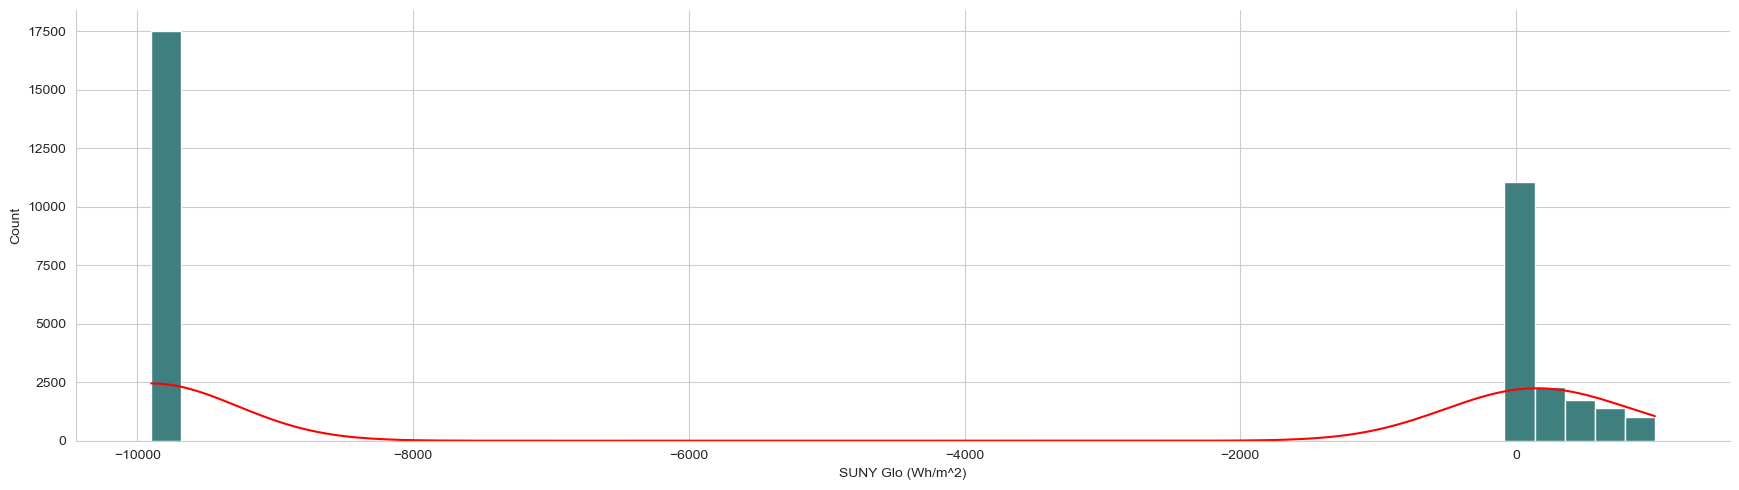

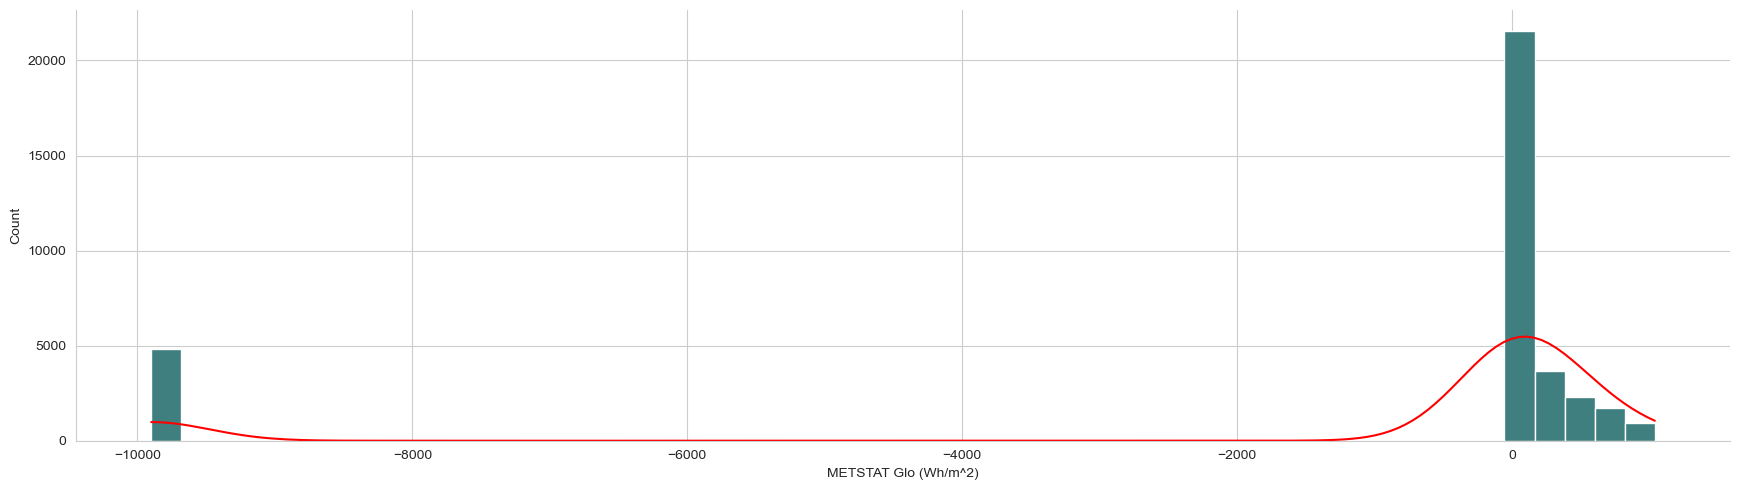

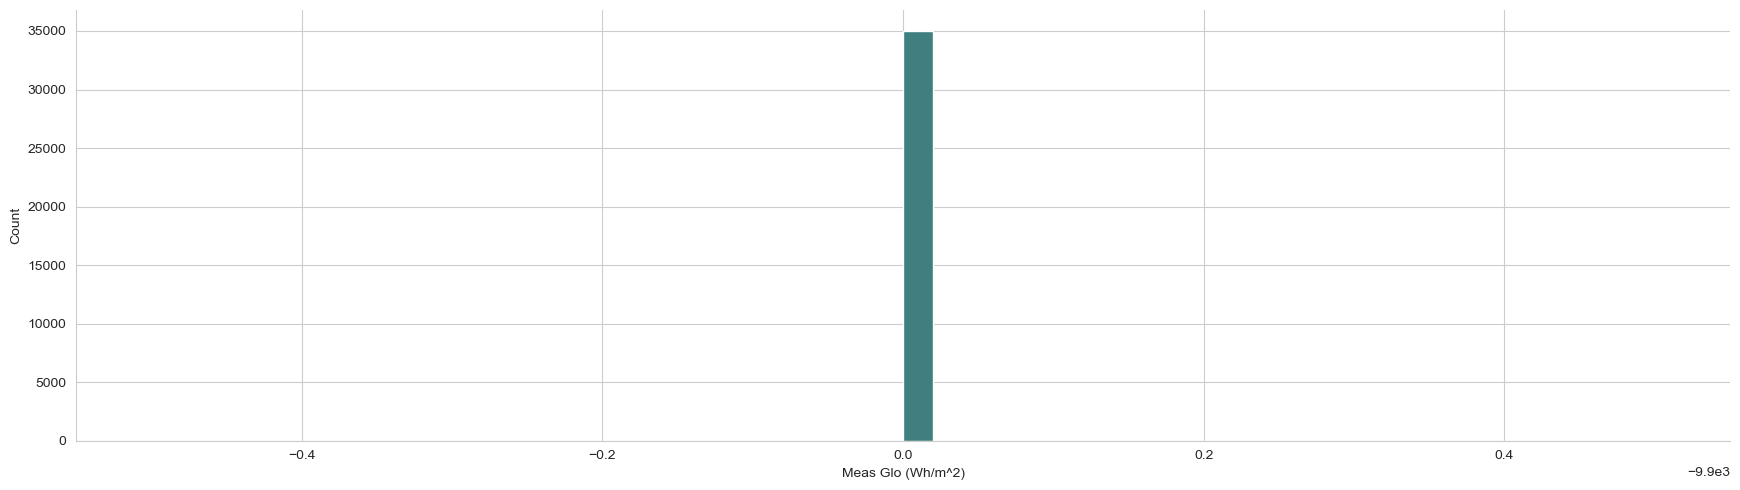

In [160]:
sns.displot(data=df, x="SUNY Glo (Wh/m^2)", kde=True, bins = 50,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);
sns.displot(data=df, x="METSTAT Glo (Wh/m^2)", kde=True, bins = 50,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);
sns.displot(data=df, x="Meas Glo (Wh/m^2)", kde=True, bins = 50,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

In this dataset unmeasured values are shown as -9900 

### Helper functions

In [161]:
# Helper function to merge columns based on the logic provided
def merge_columns(row, column_prefix):
    values = []
    
    for col_type in column_types:
        value = row[f"{col_type} {column_prefix}"]
        
        # For SUNY and METSTAT, use uncertainty for comparison
        if col_type in ['SUNY', 'METSTAT']:
            unc_value = row.get(f"{col_type} {column_prefix} Unc (%)", None)
        else:
            # For Meas, use the value itself instead of uncertainty
            unc_value = value
        
        # Only consider valid values (not -9900)
        if value != -9900:
            values.append((value, unc_value))
            
    # If type string change it to the float
    for i in range(len(values)):
        if isinstance(values[i][1], str) or isinstance(values[i][0], str):
            try: 
                values[i] = (float(values[i][0]), float(values[i][1]))
            except:
                print("Unexpected value: ", values[i])
                values.remove(values[i])
                
    
    # If no valid values, return -9900
    if not values:
        return -9900
    

    # If only one valid value, return that
    if len(values) == 1:
        return values[0][0]
    
    # If multiple valid values, choose non-zero value
    non_zero_values = [value for value in values if value[0] != 0]
    if len(non_zero_values) == 1:
        return non_zero_values[0][0]
    
    
            
            
    # If multiple non-zero, choose the one with the minimum uncertainty 
    return min(values, key=lambda x: x[1] if x[1] is not None else float('inf'))[0]


### Merge the sources

Each value in dataset is taken from one source and other sources seems as unmeasured values. That's why we will use merge these sources and get obtain the final merged collumn.

In [162]:
# Convert 'HH:MM' to timedelta and subtract 1 hour
df['time_shifted'] = pd.to_timedelta(df['HH:MM (LST)'] + ':00') - timedelta(hours=1)

# Combine 'YYYY-MM-DD' and the shifted time to form the new datetime column
df['datetime'] = pd.to_datetime(df['YYYY-MM-DD']) + df['time_shifted']

# Extract year and month only (YYYY-MM)
df['year_month'] = df['datetime'].dt.to_period('M')  # This will give YYYY-MM format

# Apply merging logic to each set of energy columns
for col_prefix in energy_columns:
    df[f"Merged {col_prefix}"] = df.apply(merge_columns, axis=1, column_prefix=col_prefix)
    
# Delete the original date and time related columns
df.drop(columns=['YYYY-MM-DD', 'HH:MM (LST)'], inplace=True)

# Delete time_shifted column
df.drop(columns=['time_shifted'], inplace=True)

# Delete  datetime column
df.drop(columns=['datetime'], inplace=True)

# Delete the orginal energy columns
type_cols = []
for col in df.columns:
    for col_type in column_types:
        if col_type in col:
            type_cols.append(col)
            break
df.drop(columns=type_cols, inplace=True)

# Convert -9900 values in merged columns to value of the one row above 
df.loc[df['Merged Glo (Wh/m^2)'] == -9900, 'Merged Glo (Wh/m^2)'] = df.loc[df['Merged Glo (Wh/m^2)'] != -9900, 'Merged Glo (Wh/m^2)'].shift(1)
df.loc[df['Merged Dir (Wh/m^2)'] == -9900, 'Merged Dir (Wh/m^2)'] = df.loc[df['Merged Dir (Wh/m^2)'] != -9900, 'Merged Dir (Wh/m^2)'].shift(1)
df.loc[df['Merged Dif (Wh/m^2)'] == -9900, 'Merged Dif (Wh/m^2)'] = df.loc[df['Merged Dif (Wh/m^2)'] != -9900, 'Merged Dif (Wh/m^2)'].shift(1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   Zenith (deg)         35040 non-null  float64  
 1   Azimuth (deg)        35040 non-null  float64  
 2   ETR (Wh/m^2)         35040 non-null  int64    
 3   ETRN (Wh/m^2)        35040 non-null  int64    
 4   Precip Wat (cm)      35040 non-null  float64  
 5   Precip Wat Flg       35040 non-null  int64    
 6   AOD (unitless)       35040 non-null  float64  
 7   AOD Flg              35040 non-null  int64    
 8   AOD RAN (unitless)   35040 non-null  float64  
 9    AOD RAN Flg         35040 non-null  int64    
 10  Ozone (cm)           35040 non-null  float64  
 11  Ozone Flg            35040 non-null  int64    
 12  Albedo (unitless)    35040 non-null  float64  
 13  Albedo Flg           35040 non-null  int64    
 14  year_month           35040 non-null  period[M]
 15  Me

In [163]:
# Merged columns value counts
"Merged Glo (Wh/m^2):", df['Merged Glo (Wh/m^2)'].value_counts()

('Merged Glo (Wh/m^2):',
 Merged Glo (Wh/m^2)
 0.0       16805
 1.0         283
 2.0         164
 3.0         127
 5.0         113
 4.0         103
 9.0          77
 8.0          77
 6.0          77
 7.0          72
 10.0         63
 19.0         61
 16.0         60
 62.0         60
 24.0         58
 29.0         58
 46.0         58
 13.0         56
 14.0         55
 23.0         54
 22.0         53
 17.0         52
 11.0         52
 12.0         52
 51.0         51
 15.0         51
 20.0         51
 32.0         49
 34.0         49
 41.0         49
 30.0         48
 56.0         47
 21.0         47
 54.0         46
 18.0         45
 47.0         45
 27.0         43
 67.0         43
 63.0         42
 40.0         42
 60.0         42
 25.0         42
 115.0        42
 53.0         41
 26.0         41
 28.0         41
 73.0         40
 42.0         40
 61.0         40
 69.0         39
 57.0         39
 81.0         39
 33.0         39
 116.0        39
 55.0         39
 183.0        38
 1

### Data Visualization again

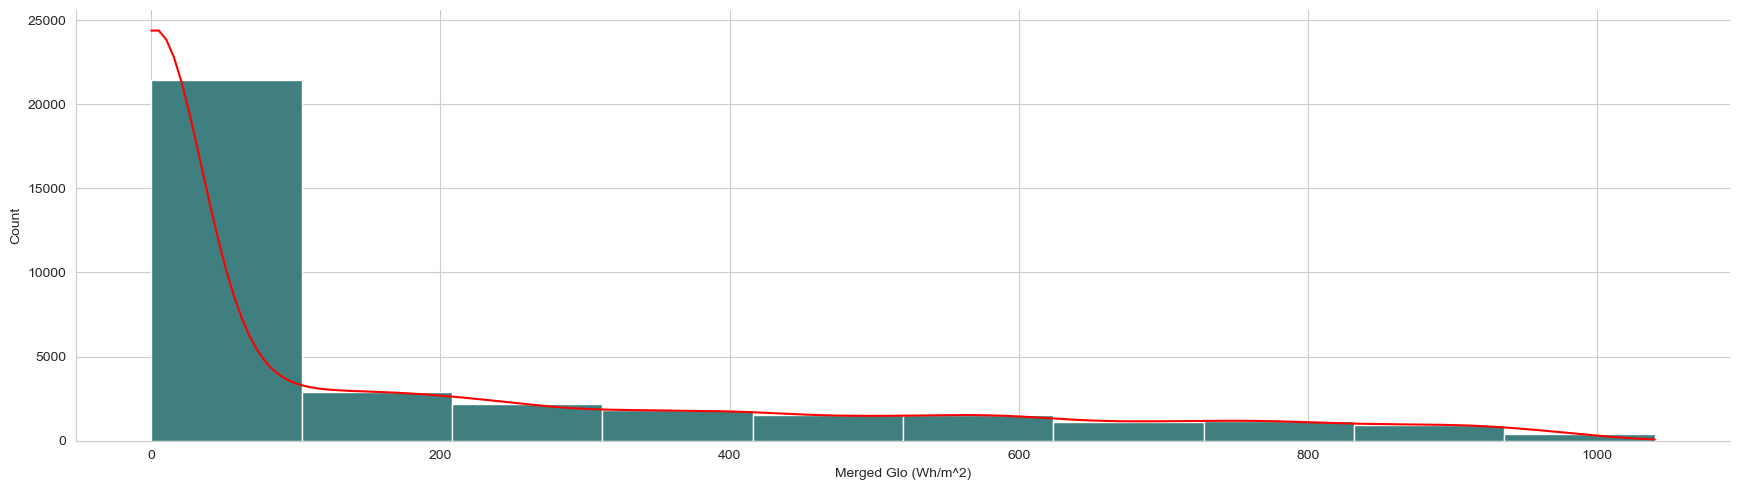

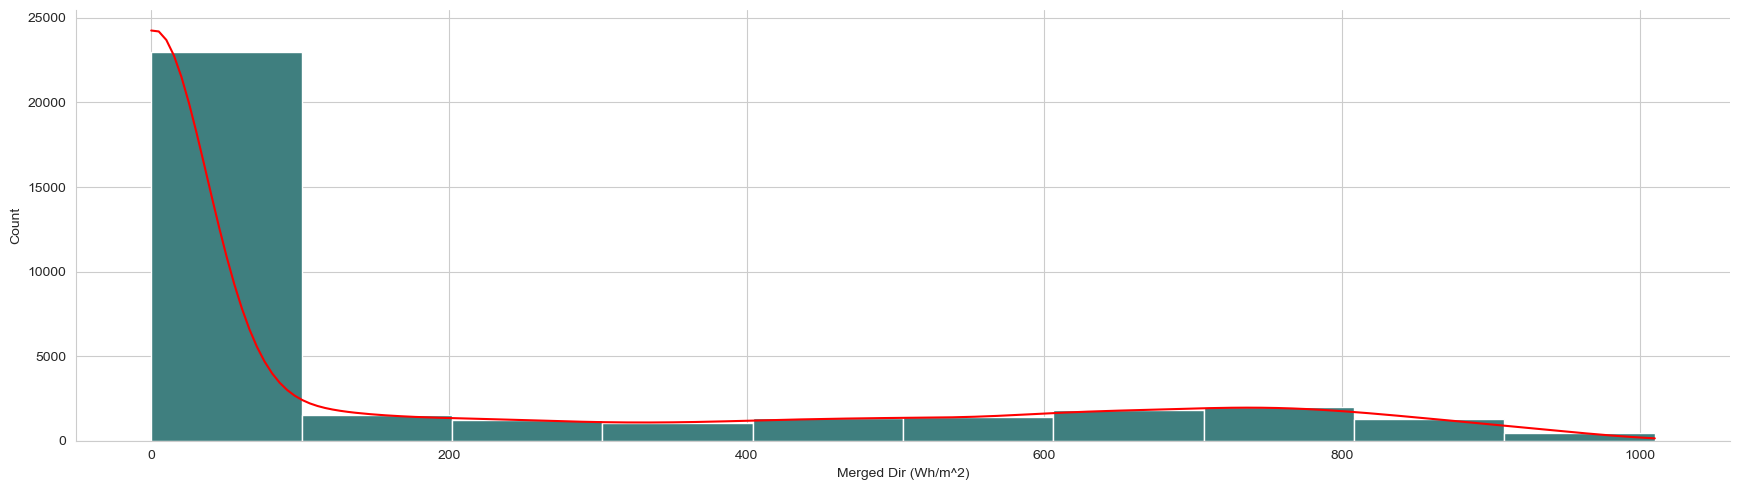

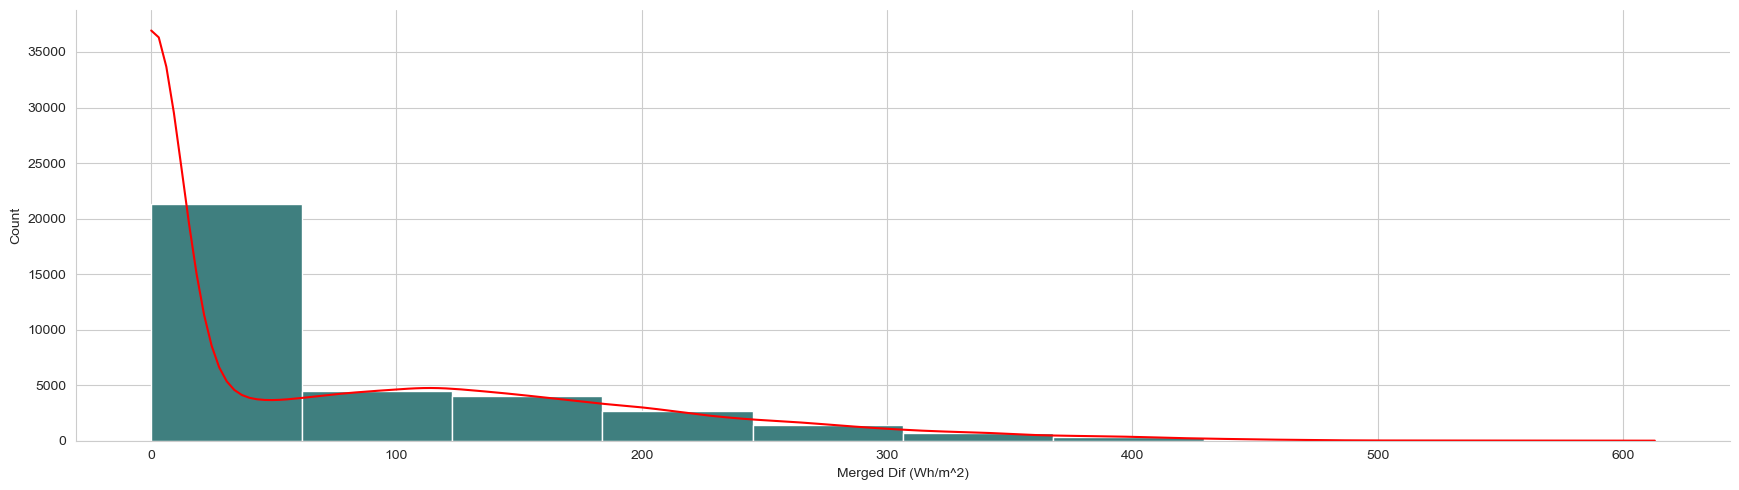

In [164]:
sns.displot(data=df, x="Merged Glo (Wh/m^2)", kde=True, bins = 10,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);
sns.displot(data=df, x="Merged Dir (Wh/m^2)", kde=True, bins = 10,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);
sns.displot(data=df, x="Merged Dif (Wh/m^2)", kde=True, bins = 10,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

In [165]:
df.columns

Index(['Zenith (deg)', 'Azimuth (deg)', 'ETR (Wh/m^2)', 'ETRN (Wh/m^2)',
       'Precip Wat (cm)', 'Precip Wat Flg', 'AOD (unitless)', 'AOD Flg',
       'AOD RAN (unitless)', ' AOD RAN Flg', 'Ozone (cm)', 'Ozone Flg',
       'Albedo (unitless)', 'Albedo Flg', 'year_month', 'Merged Glo (Wh/m^2)',
       'Merged Dir (Wh/m^2)', 'Merged Dif (Wh/m^2)'],
      dtype='object')

### Define functions

In [166]:
# Function to process each CSV file and convert hourly data to monthly
def process_file(filepath):
    df = pd.read_csv(filepath)

    # Convert 'HH:MM' to timedelta and subtract 1 hour
    df['time_shifted'] = pd.to_timedelta(df['HH:MM (LST)'] + ':00') - timedelta(hours=1)

    # Combine 'YYYY-MM-DD' and the shifted time to form the new datetime column
    df['datetime'] = pd.to_datetime(df['YYYY-MM-DD']) + df['time_shifted']

    # Extract year and month only (YYYY-MM)
    df['year_month'] = df['datetime'].dt.to_period('M')  # This will give YYYY-MM format

    # Apply merging logic to each set of energy columns
    for col_prefix in energy_columns:
        df[f"Merged {col_prefix}"] = df.apply(merge_columns, axis=1, column_prefix=col_prefix)
        
    # Delete the original date and time related columns
    df.drop(columns=['YYYY-MM-DD', 'HH:MM (LST)'], inplace=True)
    
    # Delete time_shifted column
    df.drop(columns=['time_shifted'], inplace=True)
    
    # Delete  datetime column
    df.drop(columns=['datetime'], inplace=True)
    
    # Delete the orginal energy columns
    type_cols = []
    for col in df.columns:
        for col_type in column_types:
            if col_type in col:
                type_cols.append(col)
                break
    df.drop(columns=type_cols, inplace=True)
            
    # Convert -9900 values in merged columns to value of the one row above 
    df.loc[df['Merged Glo (Wh/m^2)'] == -9900, 'Merged Glo (Wh/m^2)'] = df.loc[df['Merged Glo (Wh/m^2)'] != -9900, 'Merged Glo (Wh/m^2)'].shift(1)
    df.loc[df['Merged Dir (Wh/m^2)'] == -9900, 'Merged Dir (Wh/m^2)'] = df.loc[df['Merged Dir (Wh/m^2)'] != -9900, 'Merged Dir (Wh/m^2)'].shift(1)
    df.loc[df['Merged Dif (Wh/m^2)'] == -9900, 'Merged Dif (Wh/m^2)'] = df.loc[df['Merged Dif (Wh/m^2)'] != -9900, 'Merged Dif (Wh/m^2)'].shift(1)
    
    # Group by year and month
    monthly_df = df.groupby('year_month').agg({
        **{f"Merged {col}": 'sum' for col in energy_columns},  # Sum for merged energy values
        **{col: 'mean' for col in percentage_columns},  # Average for percentages and scalar values
        **{col: 'max' for col in angle_columns},  # Max for angle columns
        **{col: 'max' for col in flag_columns}  # Max for flags
    }).reset_index()
    
        # Maximum of 3 floating points
    monthly_df = monthly_df.round(decimals=3)

    # Save the monthly data to a new CSV file
    output_filepath = filepath.replace('/hourly/', '/monthly/')
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)
    monthly_df.to_csv(output_filepath, index=False)
    print(f"Processed {output_filepath}")



### Convert dataset to monthly

In [167]:
# Convert each CSV file in the folders
for folder in folders:
    if int(folder) > 722884:
        folder_path = "./data/1991-2005/hourly/" + folder
        for file in os.listdir(folder_path):
            try:
                if file.endswith(".csv"):
                    file_path = folder_path + "/" + file
                    process_file(file_path)
            except Exception as e:
                logg = open("log.txt", "a")
                file_path = folder_path + "/" + file
                logg.write("error in " + file_path + ": " + str(e) +  "\n")
                logg.close()


Processed ./data/1991-2005/monthly/722885/722885_1991_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1992_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1993_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1994_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1995_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1996_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1997_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1998_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_1999_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_2000_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_2001_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_2003_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_2004_solar.csv
Processed ./data/1991-2005/monthly/722885/722885_2005_solar.csv
Processed ./data/1991-2005/monthly/722886/722886_1991_solar.csv
Processed ./data/1991-2005/monthly/72288

In [168]:
df5 = pd.read_csv("./data/1991-2005/monthly/700260/700260_1999_solar.csv")

In [169]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_month           12 non-null     object 
 1   Merged Glo (Wh/m^2)  12 non-null     int64  
 2   Merged Dir (Wh/m^2)  12 non-null     int64  
 3   Merged Dif (Wh/m^2)  12 non-null     float64
 4   Precip Wat (cm)      12 non-null     float64
 5   AOD (unitless)       12 non-null     float64
 6   Ozone (cm)           12 non-null     float64
 7   Albedo (unitless)    12 non-null     float64
 8   Zenith (deg)         12 non-null     float64
 9   Azimuth (deg)        12 non-null     float64
 10  Precip Wat Flg       12 non-null     int64  
 11  AOD Flg              12 non-null     int64  
 12  Ozone Flg            12 non-null     int64  
 13  Albedo Flg           12 non-null     int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 1.4+ KB


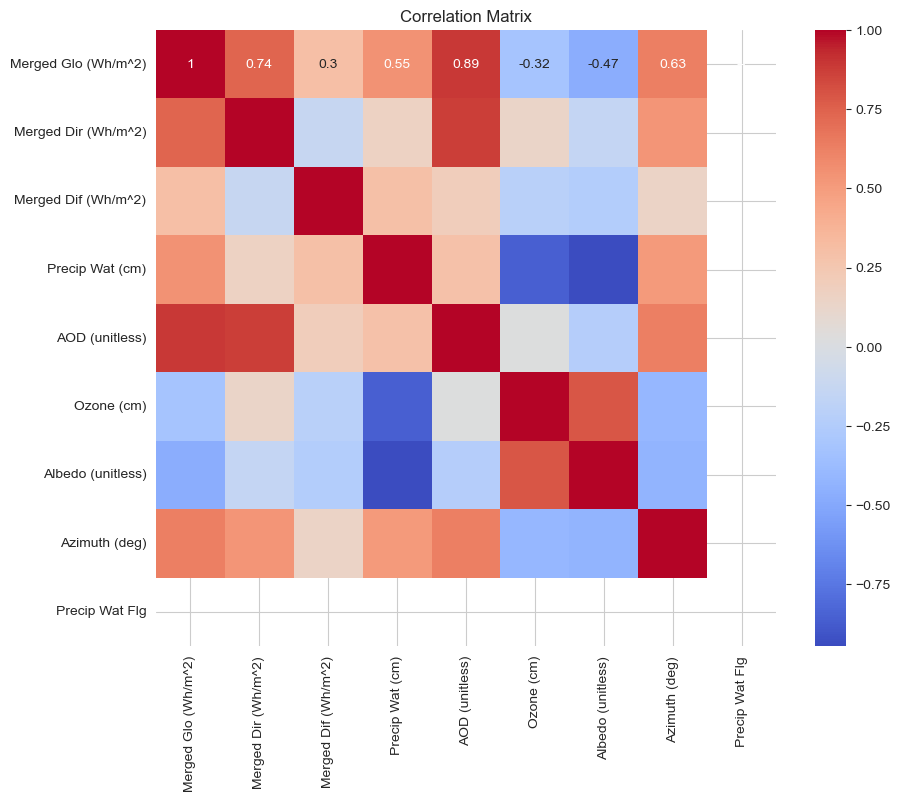

In [170]:
# Draw correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df5.drop(["year_month","Zenith (deg)", "Albedo Flg", "Ozone Flg", "AOD Flg"], axis=1,  inplace=False).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
